# Tuto 002 : Introduction of the AFT scheme
The main objective of this tutorial is the introduction of the Alternating Frequency/Time scheme in order for the Harmonic Balance Method to deal with nonlinear forces that are expressed in the time domain. The tutorial deals with the simple pendulum problem introduced in the first tutorial. By getting rid of the small displacement hypothesis, the Taylor development of the sinusoidal forcing cannot be kept. 

## Agenda :
1. Linear problem
2. Taylor developement to higher order => cubic
3. Build the sinusoidal nonlinear connector

In [1]:
## This block makes the mandatory imports and configure matplotlib for figures
## Some help function is also defined here (get_frf)
import sys
PATH_TO_PYHARM = False
PATH_TO_PYHARM = "../"
if PATH_TO_PYHARM !=False : 
    sys.path.append(PATH_TO_PYHARM)
# ------------------ IMPORTS ------------------ #
import copy
import numpy as np
import os
import matplotlib.pyplot as plt
import pyHarm
import json
import scipy.io
from pyHarm.Elements.FactoryElements import ElementDictionary
from pyHarm.Elements.ABCElement import ABCElement

# ------------------ MATPLOTLIB DEFAULT STYLE ------------------ #
plt.style.use('default')
FONT_BASE = 25
width_fig = 15
ratio_fig = (width_fig,1/(16/10.)*width_fig)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
plt.rc('xtick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_BASE)    # legend fontsize
plt.rc('axes', labelsize=FONT_BASE)
plt.rc('axes', titlesize=FONT_BASE+5) #fontsize of the title

style_plots_ref = {"frf_lin":{"linestyle":"dashed","color":np.array([0,0,0]),\
                          "label":"Linear solution"},\
                   "frf_nl_cubic":{"linestyle":"solid","linewidth":2,"color":np.array([255,140,0])/255.,\
                           "marker":".",\
                         "label":"nonlinear solution with cubic connector"},\
                   "frf_nl_aO":{"linestyle":"solid","linewidth":2,"color":np.array([255/8.,255,255/8.])/255.,\
                           "marker":".",\
                         "label":"nonlinear solution with anyOrder connector"},\
                   "frf_nl_sin":{"linestyle":"solid","linewidth":2,"color":np.array([0,140,255])/255.,\
                           "marker":".",\
                         "label":"nonlinear solution with true sinus connector"},
                  }
SAVE = False

# ------------------ function for FRF ------------------ #
def get_frf(M,indices_selection=('sub1', 0, 0)): 
    indexH = M.getIndex(*indices_selection)
    SA = [sol for sol in M.nls["FRF"].SolList if sol.flag_accepted]
    om = np.array([sol.x[-1] for sol in SA])
    ampH = np.array([np.linalg.norm(sol.x[indexH]) for sol in SA])
    return SA,om,ampH

## 1. Linear problem

![Pendule](./TutoFig/PenduleEq.png)

### Equation reminder : 
The equation ruling the angle of the pendulum is given by : 
$$\ddot{\theta} - \frac{g}{R} \theta - \frac{F^{ext}(t)}{mR} = 0$$


The first block of code is used as a preparation of the inputs necessary to pyHarm. The INP dictionary will be used as an input template 

In [2]:
# ------------------ SYSTEM CONSTRUCTION ------------------ #
m = 30.
g = 9.81
R = 1. * 2
C = 1e-1
FE = 1.2e1 + 4.

MassMatrix = np.array([[1.]])
DampMatrix = C * np.array([[1.]])
RigidMatrix = np.array([[g/R]])
LinSys = dict()
LinSys["M"] = MassMatrix
LinSys["C"] = DampMatrix
LinSys["K"] = 0 * RigidMatrix
LinSys["G"] = 0 * MassMatrix


# ------------------ INPUT CONSTRUCTION ------------------ #
INP = \
{
    "analysis": {"FRF":{
                "study":"frf",
                "puls_inf":0.1,
                "puls_sup":7.0,
                "ds_min": 1e-12,
                "ds_max": 3e-2,
                "sign_ds": 1,
                "verbose":False,
                "solver":"scipyroot",
                "predictor_options": {"verbose":False}
             }},
    "system":{"type":"Base",
              "nh":5,
              "nti":128,
            "adim": {"status": False,
                    "lc": 1.0,
                    "wc": 1.0}},

    "substructures": {
                "sub1": {
                    "matrix": LinSys,
                    "ndofs" : 1
                }
            },
    "connectors": {
        "loading": {
            "type":"CosinusForcing",
            "connect" : {"sub1":[0]},
            "dirs":[0],
            "amp" : FE / (m*R)
        },
        },


}


The first problem to be solved is gonna be the linear problem where the $\sin{(\theta)}$ has been approximated by $\theta$. To do that the next block creates first a copy of the template of input, and a connector equivalent to a LinearSpring is added to this new input. Once the inputs are ready, a `Maestro` object of pyHarm is instantiated before being operated. The "null" argument in the operate indicates that the first guess of solution is taken to be the null vector.

In [3]:
# -------------------- Linear problem -------------------- #
INP_lin = copy.deepcopy(INP) # new input from the template
# A new connector is added
INP_lin["connectors"]["linGravity"] = {"type":"LinearSpring",
                                       "connect" : {"sub1":[0]},
                                       "dirs":[0],
                                       "k" : g/R
        }
Lin = pyHarm.Maestro(INP_lin) # Creation of the Maestro
Lin.operate("null") # Run the analysis with the "null" guess as starting point

**Remark** : 

In pyHarm the connectors are defined in a dictionary. Each key in the dictionary is the name of a connector and its value shall be the definition of the element.

The connectors are all defined with the minimum following characteristics :
- *type* : corresponds to the type of element and shall be one of the key present in the `ElementDictionary` (new elements can be added interactively)
- *connect* : contains a dictionary with one or two keys/values designating which substructures and nodes are linked together. When a single substructure is given, this corresponds to a connection with the ground. When linking nodes of the same substructure, the key `INTERNAL` shall be used as second key in the definition. The nodes are given inside a list by convention even if a single node can be given for now.
- *dirs* : gives the direction of the connection or on which dof number the nodes are connected. Directions can be coupled and a list of multiple directions can be given [0,2] (Here only the direction [0] exists as we deal with a 1D problem)

Then other parameters can be asked to define the Element fully (e.g. `k` in the case of the `LinearSpring`)

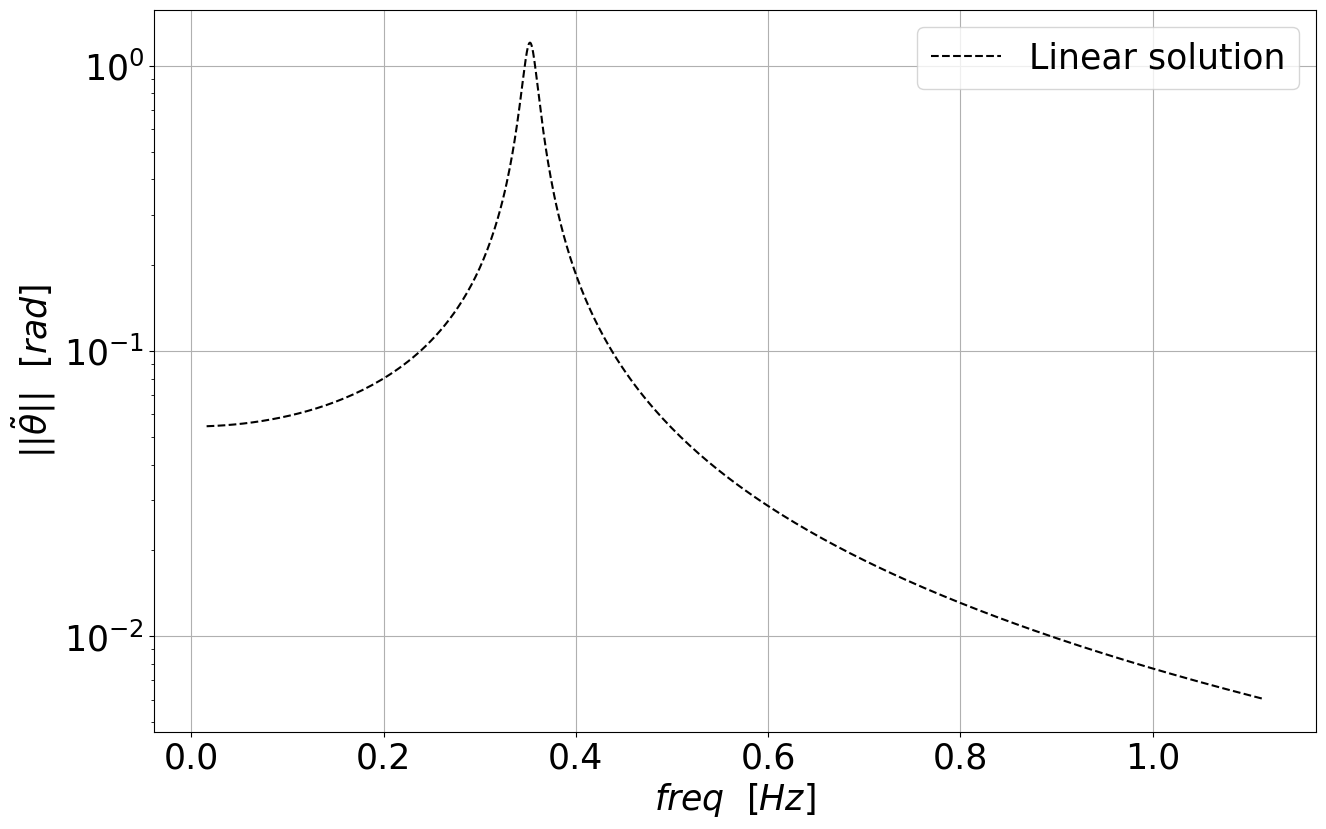

In [4]:
# -------------------- Draw of the frf -------------------- #
SA_lin, om_lin, ampH_lin = get_frf(Lin) # from the Maestro object, we extract some FRF by run the 
# get_frf function defined at the top of the notebook

fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(om_lin/(2*np.pi),ampH_lin,**style_plots_ref["frf_lin"])
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("$\|\| \\tilde{\\theta} \|\|~~[rad]$")
ax.legend()
ax.grid()
ax.set_yscale("log")


## 2. Taylor development to higher order

### Taylor development to order 3
To linearize the problem a Taylor development to the order one has been made. We propose in this part of the tutorial to increase the order of the development until the order three. This modifies the equation 

$$\ddot{\theta} - \frac{g}{R} (\theta - \frac{1}{6}\theta^{3}) - \frac{F^{ext}(t)}{mR} = 0$$

The modification of the equation introduces a nonlinear term of order 3 on the theta which modifies the behavior of the system. The next block is using one of the nonlinear connectors proposed in pyHarm to introduce this new effect. This is done here by using the `CubicSpring`, but a more general element `GeneralOrderElement` allows the creation of polynomial connectors on the fly of any order and any order of derivation of the displacement.

In [5]:
# Here we print all the accessible connectors and elements available in pyHarm to this day
for e in list(ElementDictionary.keys()) : 
    print(e)

GOElement
LinearDamper
LinearSpring
CubicSpring
PenaltyBilateralGap
PenaltyBilateralGapFriction
PenaltyUnilateralGap
Jenkins
Penalty3D
DLFTUniGap
DLFT3D
DLFTFriction
GOForcing
CosinusForcing
SinusForcing
substructure
GOMatrix
linear_hysteretic


**Remark** : 

For people that are more used to HBM codes, they might notice that the forcings are also into the dictionary of Elements which is not usual because the forcing does usually not depend on displacement. In pyHarm an element is defined as any object that would contribute to the residual equation. Those elements and connectors are all based onto the same abstract class `ABCElement` that defines a protocol ensuring that pyHarm is able to use those objects. The substructures themselves are also complying with this class while having the peculiarity of being the only subclass that is able to create new nodes and dofs into the system. 




In [6]:
from Tuto_002_AFTscheme_correctionfunctions import cubic_problem_corr
# -------------------- Cubic problem -------------------- #
INP_cub = copy.deepcopy(INP)
# The linearSpring connector is added like previously
INP_cub["connectors"]["linGravity"] = {
    "type":"LinearSpring",
    "connect" : {"sub1":[0]},
    "dirs":[0],
    "k" : g/R
        }
# Now we add a new connector corresponding to the cubic part using a "CubicSpring" type
def cubic_problem(g,R):
    return 0 # to be modified
INP_cub["connectors"]["cubicGravity"] = {
    "type":"CubicSpring",
    "connect" : {"sub1":[0]},
    "dirs":[0],
    "k" : cubic_problem_corr(g,R) # introduces the value of the coefficient to allocate to the cubic spring
        }
Cub = pyHarm.Maestro(INP_cub)
Cub.operate("null")

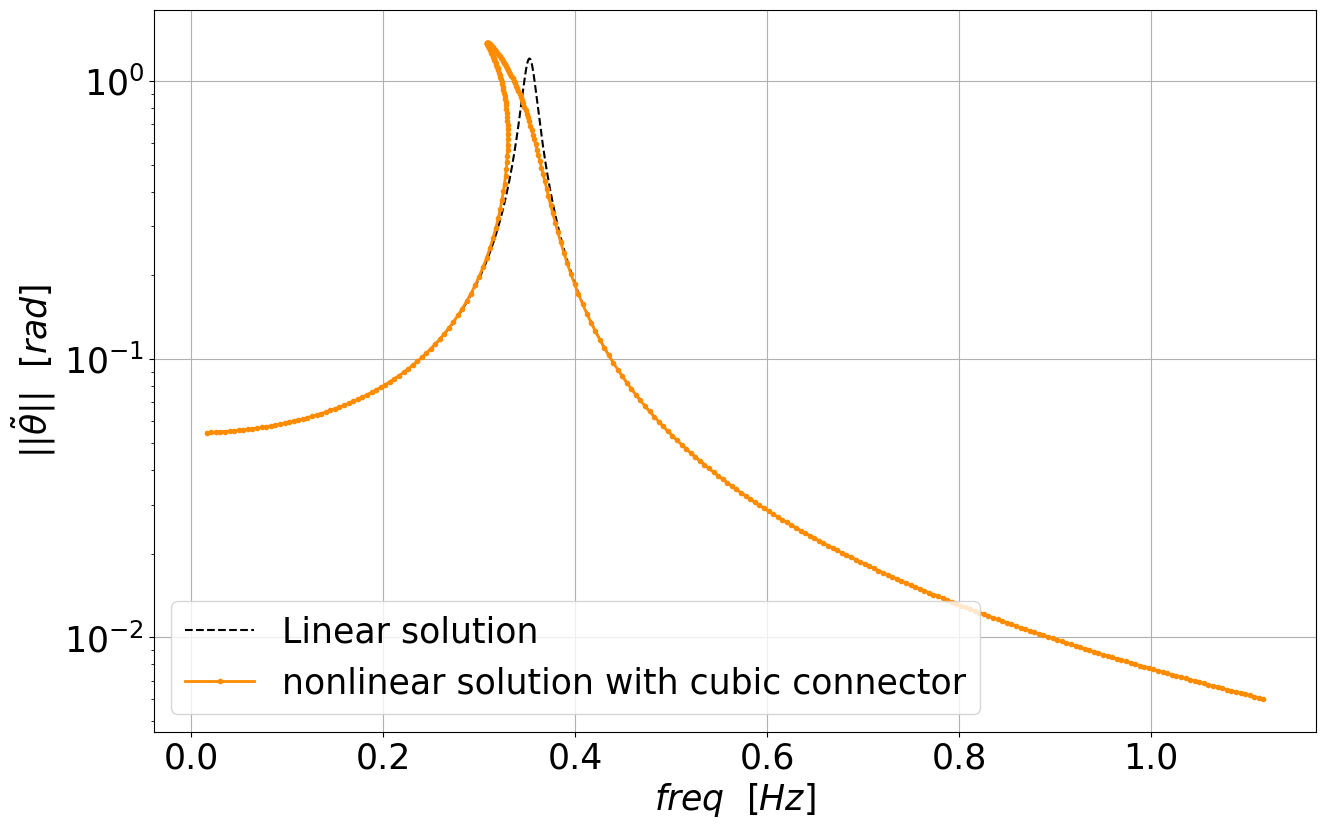

In [7]:
SA_cub, om_cub, ampH_cub = get_frf(Cub)

fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(om_lin/(2*np.pi),ampH_lin,**style_plots_ref["frf_lin"])
ax.plot(om_cub/(2*np.pi),ampH_cub,**style_plots_ref["frf_nl_cubic"])
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("$\|\| \\tilde{\\theta} \|\|~~[rad]$")
ax.legend()
ax.grid()
ax.set_yscale("log")


When the amplitudes start to increase, the effects of the nonlinearity starts to have more and more impact on the actual response of the system. The effect of the nonlinearities here has a softening behavior with the appearance of turning points that require the curve to decrease in frequency while still increasing in amplitude. This phenomenon imposes the code to be enhanced with specific methods that allow the correct following of the FRF. This is seen in more detail in the tutorial 003 where the prediction/correction method is studied. 


Because this connector is nonlinear a special treatment needs to be done by the code and this treatment will be explained more carefuly in the next sections. But before going further we propose to enhance our model by integrating even higher order of the Taylor expansion. The Taylor expansion of the sinusoidal function around 0 is given below : 

$$ \sin{(\theta)} = \sum_{n=0}^{N} \frac{(-1)^{n}}{(2 \cdot n+1)!}x^{2\cdot n + 1} $$

The connector called `GeneralOrderElement` is gonna be used in order to provide polynomial connectors to the system.

In [8]:
# Corrected functions 
from Tuto_002_AFTscheme_correctionfunctions import x_order_corr, taylor_factor_sinus_corr
# Create a python function that compute the value of the Taylor coefficient 
# depending on the order of the coefficient that is asked
def taylor_factor_sinus(n):
    return 0 # to be modified 
def x_order(n):
    return 0 # to be modified


MaxOrder = 2 # User can play with this parameter to add more and more connectors with higher order
INP_anyOrder = copy.deepcopy(INP)
for n in range(MaxOrder+1) : 
    name_co = f"GravityPolynomOrder_{2*n+1:03d}" # just to have a name
    INP_anyOrder["connectors"][name_co] = {
        "type":"GOElement",
        "connect" : {"sub1":[0]},
        "dirs":[0],
        "dto":0, # order of the time derivative, here kept to 0
        "xo":x_order_corr(n), # here put the order of the polynomial depending of n
        "k" : g/R * taylor_factor_sinus_corr(n) # here include the factor of the taylor development
        }
    

anyOrder = pyHarm.Maestro(INP_anyOrder)
anyOrder.operate("null")

(0.1, 3.0)

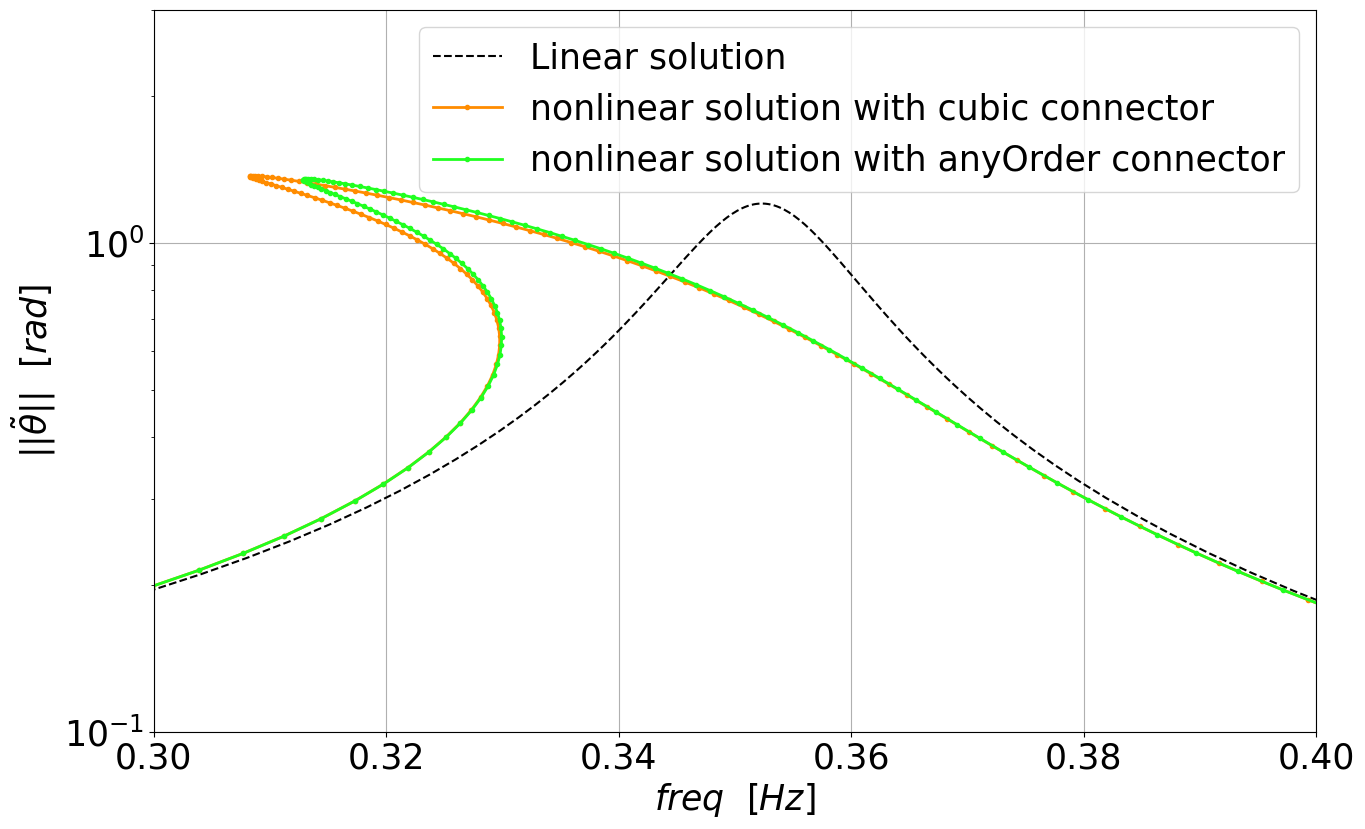

In [9]:
SA_aO, om_aO, ampH_aO = get_frf(anyOrder)

fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(om_lin/(2*np.pi),ampH_lin,**style_plots_ref["frf_lin"])
ax.plot(om_cub/(2*np.pi),ampH_cub,**style_plots_ref["frf_nl_cubic"])
ax.plot(om_aO/(2*np.pi),ampH_aO,**style_plots_ref["frf_nl_aO"])
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("$\|\| \\tilde{\\theta} \|\|~~[rad]$")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlim(.3,.4)
ax.set_ylim(1e-1,3e0)

Polynomial expansion of the sinusoidal function could be entirely treated in the frequency space as it is possible to obtain a close form for this problem. Recall that our displacement in time domain is as follows : 

$$x(t) = c_0 + \sum_{n=1}^{n_h} c_n \cos{(n t)} + s_n \sin{(n t)} \approx c_0 + c_1 \cos{(t)} + s_1 \sin{(t)} $$

If we consider a force that is proportional to the displacement at the power 2 : 

$$ f(t) \propto (c_0 + c_1 \cos{(t)} + s_1 \sin{(t)})^{2} $$ 

This will generate the following terms ; 
- $\cos^{2}{(t)} = \frac{1}{2}(1+\cos{(2t)})$
- $\sin^{2}{(t)}= \frac{1}{2}(1-\cos{(2t)})$
- $\cos{(t)}\cdot \sin{(t)} = \frac{1}{2}\sin{(2t)}$

This shows that it is possible to develop this kind of polynomial effects using directly the frequency domain and a branch of HBM relies on this hypothesis. But when dealing with more complex functions, a closed form is no longer available. An other remark is that the quadratic nonlinearity here gives birth to response with higher frequency number $(\cos{(2t)},\sin{(2t)})$, suggesting to solve the Harmonic Balance considering more harmonics when nonlinear effects are present. 

A second solution that allows for more generic and tricky nonlinearities is the use of the AFT scheme for *Aternating Frequency/Time scheme*. The idea behind this method is to use discrete Fourier operators to loop from frequency to temporal domain. Thus making it possible to use the closed form of the nonlinear effort directly in the time domain before going back to the frequency domain.

The following block is using discrete Fourier operator to show how the procedure works. Let's consider a pure sinusoidal displcement of amplitude 1 $x(t) = sint(t)$. In the Fourier space it means that the $x(t)$ can be expressed with a single non null coefficient.

<BarContainer object of 11 artists>

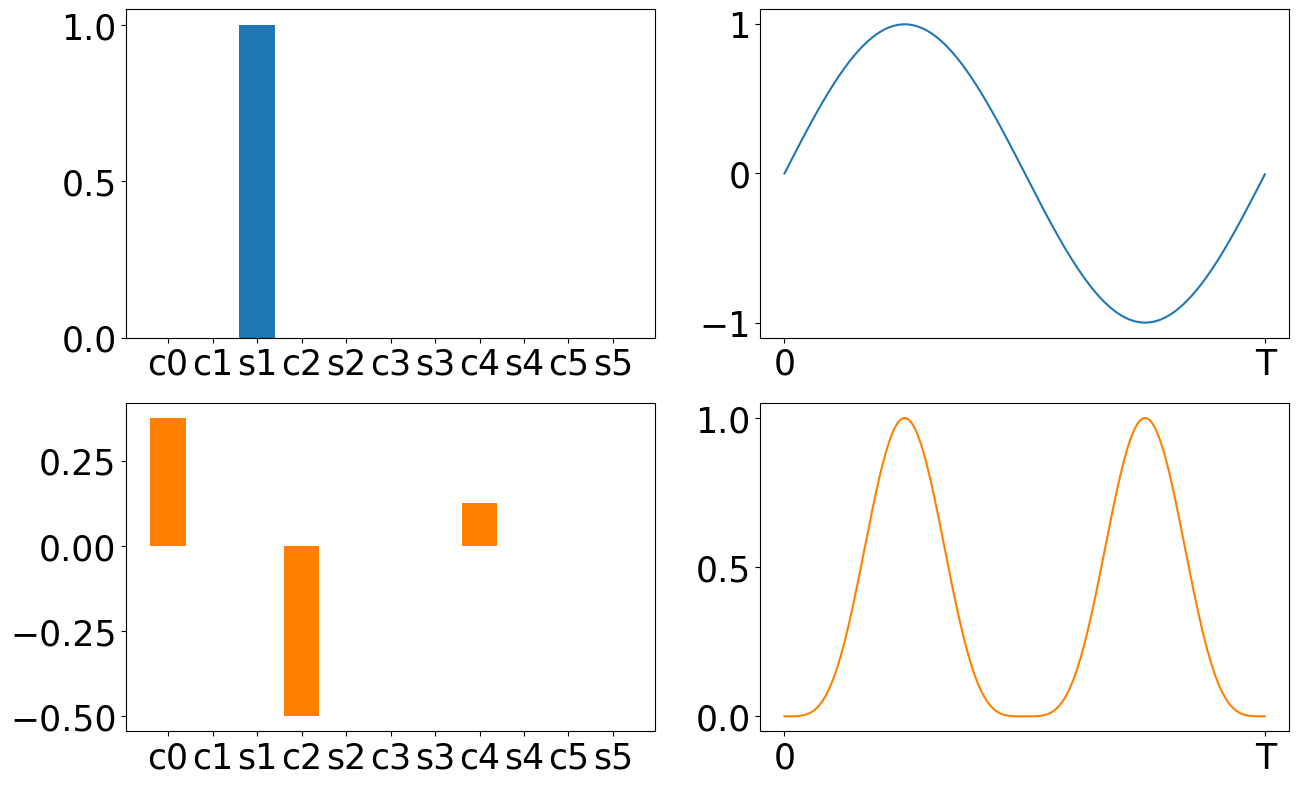

In [11]:
from pyHarm.DynamicOperator import compute_DFT
nh  = 5 # you can play with those parameters
nti = 1024 # you can play with those parameters
D = compute_DFT(nti, nh) # Here we build the Fourier operators 
# corresponding to the number of harmonic nh taken into account and for a certain time discretization
DFT, DTF = D["ft"], D["tf"]

# let's consider a displacement that is a pure sin(t) of amplitude 1. 
x_h = np.zeros(2*nh+1,)
x_h[2] = 1 # x_h[0] is the constant coef, x_h[1] is the coef for the first cosine
x_t = x_h @ DFT

# We now apply a transformation on the time displacement
def deformation(x_t): # you can try any function of your liking
    return x_t**4

fig,AX = plt.subplots(2,2,figsize=ratio_fig)
def label(i): 
    if i == 0 :
        return "c0"
    else : 
        if i%2 == 0:
            return f"s{(i+1)//2}"
        else : 
            return f"c{(i+1)//2}"
for ax in AX[:,0]:
    ax.set_xticks(np.arange(2*nh+1))
    ax.set_xticklabels([label(i) for i in (np.arange(2*nh+1))])
for ax in AX[:,1]:
    ax.set_xticks([0,nti])
    ax.set_xticklabels(["0","T"])

AX[0,0].bar(np.arange(2*nh+1),x_h)
AX[0,1].plot(x_t)
AX[1,1].plot(deformation(x_t),color=np.array([1,.5,0]))
AX[1,0].bar(np.arange(2*nh+1),deformation(x_t)@DTF,color=np.array([1,.5,0]))

## 3. Build the nonlinear sinus connector

In order to apply forces expressed in the time domain when a closed form is not necessarly available in the frequency domain, a mean is to use discrete Fourier operator to obtain the time displacement. 

The force can then be expressed during a full period using the available closed form in the time domain. In order to obtain the force in the frequency domain, one applies the Fourier transform back. This alternation of frequency and time space is called the AFT scheme and is used extensively in pyHarm for calculating the nonlinear forces that are expressed in the time domain. This is the case of the sinusoidal force of the gravity present in our pendulum equation. 

In the next block we propose to create a new nonlinear element complying with the Abstract class `ABCElement`. In this tutorial the creation of the sinus connector using the class is already provided, and only the function that calculates the sinus will have to be coded. It is advised to look at the structure of the class defining the whole element in order to better understand their construction.

In [12]:
from Tuto_002_AFTscheme_correctionfunctions import sinR_corr
from pyHarm.BaseUtilFuncs import pyHarm_plugin
# -- Creation du connecteur -- #
### This is the function to be completed by the student ### 
def sinR(x,om,Pslave,DFT,DTF,k):
    x_dofs = (Pslave) @ x # Pslave is used to obtain the right degrees of freedom
    # below code the obtention of the temporal displacement by using the inverse discrete Fourier operator DFT
    x_t = 0 # to be modified
    # Once the displcement is known in the temporal space the force can be calculated
    sin_x_t = 0 # to be modified
    # Once the effort is obtained in temporal space, we need to put it back in the frequency space using DTF
    sin_x_h = np.zeros(x_dofs.shape) # to be modified
    return sin_x_h

### This class does not need any change
# Every element or connector in pyHarm is an ABCElement. This allows pyHarm to be sure that any connector
# complies with a certain protocol that can be used during calculation
# The abstract class requires the user to add at least an evalResidual, evalJacobian and adim method, if those methods 
# are not provided, no instance of this object will be authorized
from pyHarm.Elements.NodeToNodeElements.NodeToNodeElement import NodeToNodeElement
class SinusE(NodeToNodeElement): 
    factory_keyword = "sinus"
    def __post_init__(self,):
        # The post_init method allows the user to obtain more information from the input data and save it
        # Here we want to store the proportional coefficient of the force
        self.k = self.data["k"]
    def adim(self,):
        # The adim method will not be coded in this part and its use will be seen in future tutorials
        pass
    def evalResidual(self,xg,om): 
        # This is the method that evaluates the residual of the connector
        x = xg[self.indices] # from the global displacement of the whole structure, obtains the dofs of interest
        self.R = sinR_corr(x, om, self.Pslave, self.D["ft"], self.D["tf"],self.k) # apply the function previously coded
        return self.R
    def evalJacobian(self, xg, om):
        # This is the method to evaluate the Jacobian
        # Here we use the method provided in the abstract class to compute the Jacobian thanks to 
        # a Finite Difference method
        self.J,self.dJdom = self._evalJaco_DF(xg, om, 1e-5)
        return self.J, self.dJdom
    
### This step adds the previously defined element to be added to the connector library and be available to pyHarm
pyHarm_plugin(SinusE)


In [13]:
# ------------------ PYHARM MAESTRO CONSTRUCTION ------------------ #
INP_sin = copy.deepcopy(INP)
INP_sin["connectors"]["SinGravity"] = {"type":"sinus",
                                       "connect" : {"sub1":[0]},
                                       "dirs":[0],
                                       "k" : g/R
        }
Sin = pyHarm.Maestro(INP_sin)
Sin.operate("null")

(0.1, 3.0)

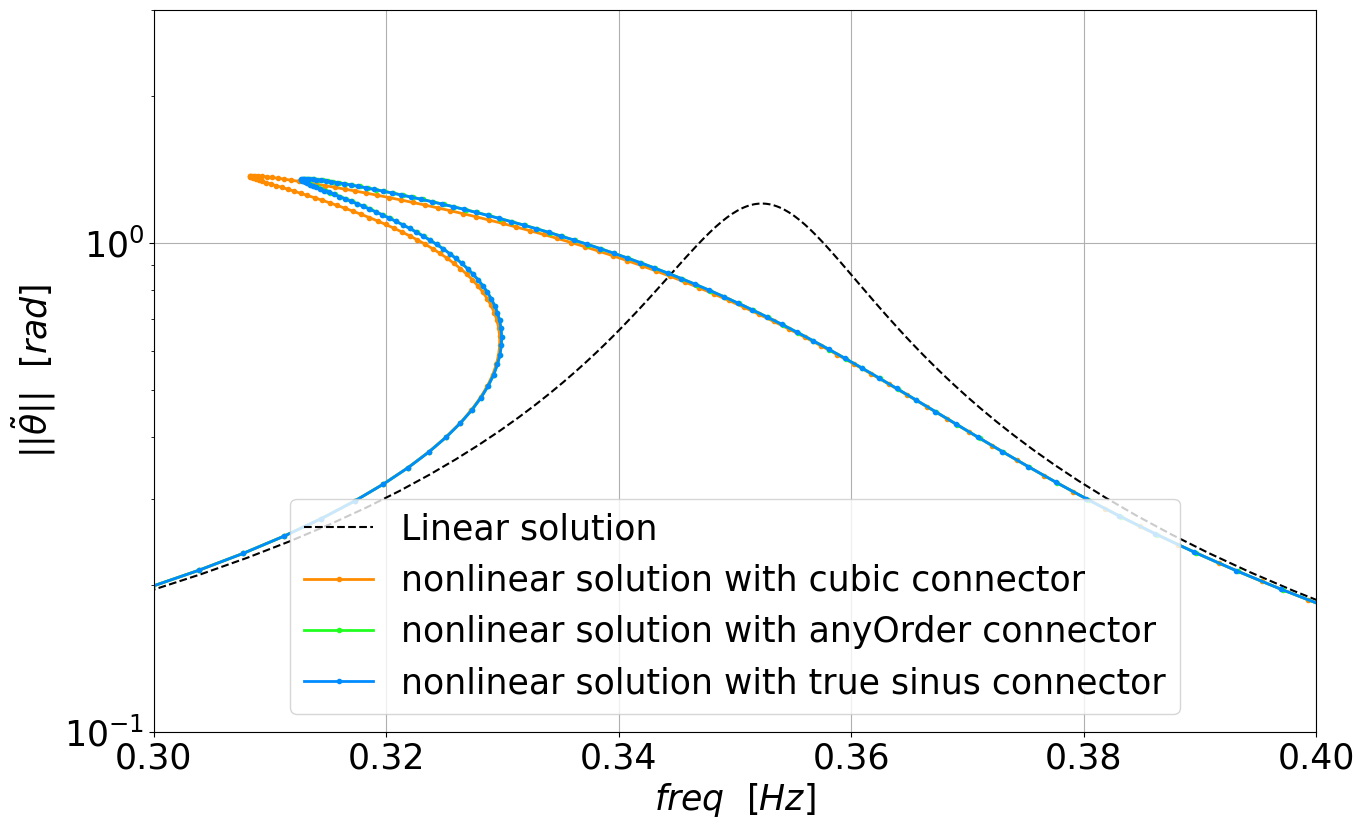

In [14]:
SA_sin, om_sin, ampH_sin = get_frf(Sin)

fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(om_lin/(2*np.pi),ampH_lin,**style_plots_ref["frf_lin"])
ax.plot(om_cub/(2*np.pi),ampH_cub,**style_plots_ref["frf_nl_cubic"])
ax.plot(om_aO/(2*np.pi),ampH_aO,**style_plots_ref["frf_nl_aO"])
ax.plot(om_sin/(2*np.pi),ampH_sin,**style_plots_ref["frf_nl_sin"])
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("$\|\| \\tilde{\\theta} \|\|~~[rad]$")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlim(.3,.4)
ax.set_ylim(1e-1,3e0)

## Conclusion 

The AFT scheme is a method that uses discrete Fourier operator to express nonlinear forces with a closed form into the time domain. This scheme is extensively used in pyHarm and is the most popular method to compute nonlinear forces and effects in the HBM framework. 

By the end of this notebook, you should be more familiar with some of the key concepts of pyHarm such as the `ABCElement` class that defines a protocol for all the connectors. Moreover, in pyHarm any object that has a contribution to the residual equation must comply with this abstract class.

In the next tutorial, the focus is put on bifurcations and the methods that are necessary to deal with them. 